In [1]:
import numpy as np
np.set_printoptions(precision=5)

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.params import Default, NumberParam
from nengo.dists import Uniform
from nengo.neurons import *
from nengo.builder.neurons import *
from nengo.dists import Uniform
from nengo.solvers import LstsqL2, NoSolver
from nengo.base import ObjView
from nengo.builder import Builder, Operator, Signal
from nengo.exceptions import BuildError
from nengo.builder.connection import build_decoders, BuiltConnection
from nengo.utils.builder import full_transform

from nengolib.signal import s, z, nrmse, LinearSystem
from nengolib import Lowpass, DoubleExp

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

import time

import neuron
neuron.h.load_file('./NEURON/durstewitz/durstewitz.hoc')
neuron.h.load_file('stdrun.hoc')

	1 


1.0

In [15]:
class DurstewitzNeuron(NeuronType):
    
    probeable = ('spikes', 'voltage')

    def __init__(self, v0=-65.0, dt_neuron=0.025, DA=False):
        super(DurstewitzNeuron, self).__init__()
        self.v0 = v0
        self.dt_neuron = dt_neuron
        self.DA = DA  # dopaminergic modulation ON/OFF

    def neuron_rates(self, wgain, wbias, x, n_neurons_test, stage, dt=0.001, tau=0.1, max_rate_pre=20):
        rate_pos = (max_rate_pre/2) * (x + 1)
        rate_neg = (max_rate_pre/2) * (-x + 1)
        spike_counts = np.zeros_like(n_neurons_test)
        neurons = []
        spk_vecs = []
        spk_recs = []
        stims = []
        syns = []
        ncs = []
        for n in range(n_neurons_test):
            neurons.append(neuron.h.Durstewitz())
            neurons[n].init()
            spk_vecs.append(neuron.h.Vector())
            spk_recs.append(neuron.h.APCount(neurons[n].soma(0.5)))
            spk_recs[n].record(neuron.h.ref(spk_vecs[n]), dt*1000)
            for loc in [neurons[n].basal(0.5), neurons[n].prox(0.5), neurons[n].dist(0.5)]:
                if stage == 'gain':
                    # bias spikes
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = -70 if wbias < 0 else 0
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, np.abs(wbias)))
                    ncs[-1].pre().interval = 1
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
                    w = wgain[n]
                    # positive encoder presynaptic neuron
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = 0
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, w))
                    ncs[-1].pre().interval = 1000.0 / rate_pos
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
                    # negative encoder presynaptic neuron
                    if rate_neg <= 0: continue
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = -70
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, w))
                    ncs[-1].pre().interval = 1000.0 / rate_neg
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
                elif stage == 'bias':
                    # bias spikes
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = -70 if wbias[n] < 0 else 0
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, np.abs(wbias[n])))
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
                    ncs[-1].pre().interval = 1
                    # positive encoder presynaptic neuron
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = 0
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, wgain))
                    ncs[-1].pre().interval = 1000.0 / rate_pos
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
                    # negative encoder presynaptic neuron
                    if rate_neg <= 0: continue
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = -70
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, wgain))
                    ncs[-1].pre().interval = 1000.0 / rate_neg
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
        settle_time = 0.1
        sim_time = 1.0
        neuron.h.tstop = (settle_time+sim_time)*1000
        neuron.h.dt = self.dt_neuron
        neuron.h.run()
        spike_counts = [np.where(np.array(sts) > settle_time*1000)[0].shape[0] for sts in spk_vecs]
        for n in range(n_neurons_test):
            spk_vecs[n].play_remove()
            del(neurons[0])
        rates = np.array(spike_counts)/sim_time
        return rates
        
    def gain_bias(self, max_rates, intercepts,
            attempts=15, steps=10, y_thr=4, x_thr=2, delta_gain=3e-5, delta_bias=1e-5):
        print('finding gain and bias assuming on/off spiking inputs...')
        max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
        intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)
#         print('max_rates', max_rates)
#         print('intercepts', intercepts)
        n_neurons = max_rates.shape[0]
        gain = np.zeros((n_neurons))
        bias = np.zeros((n_neurons))
        for n in range(n_neurons):
            wgain_min = 0.0
            wgain_max = 1e-3
            wbias_min = -3e-6
            wbias_max = 3e-6
            gain_pass = False
            bias_pass = False
            min_x_int = 1e10
            max_delta = 0
            gain_best = 1e-10
            bias_best = 1e-10
#             print('target y-int', max_rates[n])
#             print('target x-int', intercepts[n])
            for a in range(attempts):
                if a == 0:
                    wbias = 0
                '''find wgain that achieve max_rates[n] at x=1 given previous wbias'''
                if not gain_pass:
                    wgain = np.linspace(wgain_min, wgain_max, steps)
                    y_rates = self.neuron_rates(wgain, wbias, x=1, n_neurons_test=steps, stage='gain')
#                     print('wgain', wgain)
#                     print('y_rates', y_rates)
                    wgain = wgain[np.argmin(np.abs(y_rates - max_rates[n]))]
                    y_int = y_rates[np.argmin(np.abs(y_rates - max_rates[n]))]
                else:
                    y_int = self.neuron_rates([wgain], wbias, x=1, n_neurons_test=1, stage='gain')
                '''find wbias that achieve 0<hz<1 at x=intercept[n] given previous wgain'''
                if not bias_pass:
                    wbias = np.linspace(wbias_min, wbias_max, steps)
                    x_rates = self.neuron_rates(wgain, wbias, x=intercepts[n], n_neurons_test=steps, stage='bias')
#                     print('wbias', wbias)
                    if (x_rates > x_thr).all() or (x_rates <= 0).all():
                        wbias = wbias[0]
                        x_int = x_rates[0]
                    else:
                        wbias = wbias[np.where(x_rates <= x_thr)[0][-1]]
                        x_int = x_rates[np.where(x_rates <= x_thr)[0][-1]]
                else:
                    x_int = self.neuron_rates(wgain, [wbias], x=intercepts[n], n_neurons_test=1, stage='bias')
                a_y_int = self.neuron_rates([wgain], wbias, x=1, n_neurons_test=1, stage='gain')
                a_x_int = self.neuron_rates(wgain, [wbias], x=intercepts[n], n_neurons_test=1, stage='bias')
#                 print('attempt %s' %a)
#                 print('rate at y-int', a_y_int)
#                 print('rate at x-int', a_x_int)
                if 0 < a_x_int <= min_x_int:
                    min_x_int = a_x_int
                    if a_y_int-a_x_int > max_delta:
                        max_delta = a_y_int-a_x_int
                        gain_best = wgain
                        bias_best = wbias
                if a_x_int > a_y_int:  # oversaturated
                    wgain_max -= 3*delta_gain
                    wbias_min -= 3*delta_bias
                    wbias_max -= 3*delta_bias
                if np.abs(a_y_int - max_rates[n]) <= y_thr:
                    gain_pass = True
                elif a_y_int < max_rates[n] - y_thr:
                    wgain_min += delta_gain/2
                    wgain_max += delta_gain
                    gain_pass = False
                elif a_y_int > max_rates[n] + y_thr:
                    wgain_min -= delta_gain
                    wgain_max -= delta_gain/2
                    gain_pass = False
                if 0 < a_x_int <= x_thr:
                    bias_pass = True
                elif a_x_int > x_thr:
                    wbias_min -= delta_bias
                    wbias_max -= delta_bias/2
                    bias_pass = False
                elif a_x_int <= 0:
                    wbias_min += delta_bias/2
                    wbias_max += delta_bias
                    bias_pass = False
                if gain_pass and bias_pass:
                    print('optimized neuron %s' %n)
                    gain[n] = wgain
                    bias[n] = wbias
                    break
                if a == attempts-1:
                    print('did not find good gain/bias for neuron %s' %n)
                    # use the highest rate / largest intercept found during optimization instead
                    gain[n] = gain_best
                    bias[n] = bias_best
            final_rate_y_int = self.neuron_rates([wgain], wbias, x=1, n_neurons_test=1, stage='gain')
            final_rate_x_int = self.neuron_rates(wgain, [wbias], x=intercepts[n], n_neurons_test=1, stage='bias')
#             print('final rate y int', final_rate_y_int)
#             print('final rate x int', final_rate_x_int)
#         self.gain = gain
#         self.bias = bias
#         self.max_rates = max_rates
#         self.intercepts = intercepts
        return gain, bias
        
    def max_rates_intercepts(self, gain, bias, xsteps=21):
        """Measure firing rate at each eval_point using neuron_rates, estimate x_int and rate at y_int"""
        return self.max_rates, self.intercepts
#         print('estimating max_rates and intercepts from provided gain/bias...')
#         n_neurons = gain.shape[0]
#         xs = np.linspace(-1, 1, xsteps)
#         rates = np.zeros((xsteps, n_neurons))
#         for x in range(xsteps):
#             for n in range(n_neurons):
#                 rates[x, n] = self.neuron_rates([gain[n]], bias[n], xs[x], 1, 'gain')
#         max_rates = rates[-1]
#         intercepts = np.zeros((n_neurons))
#         for n in range(n_neurons):
#             if (rates[:,n] <= 0).all():
#                 warnings.warn("neuron %s not firing in max_rates_intercepts" %n)
#                 intercepts[n] = 0
#             else:    
#                 intercepts[n] = xs[np.where(rates[:,n] > 0)[0][0]]
#         print('max rates', max_rates)
#         print('intercepts', intercepts)
# #         self.max_rates = max_rates
# #         self.intercepts = intercepts
#         return max_rates, intercepts
    
    def step_math(self, v_recs, spk_vecs, spk_recs, spk_before, voltage, spiked, time, dt):
        n_neurons = voltage.shape[0]
#         spk_before = np.array([np.array(spk_vecs[n]) for n in range(n_neurons)])
        if neuron.h.t < time*1000:  # Nengo starts at t=dt
            neuron.h.tstop = time*1000
            neuron.h.continuerun(neuron.h.tstop)
        for n in range(n_neurons):
            if not np.isfinite(v_recs[n][-1]):
#                 warnings.warn('neuron %s returned nan voltage at t=%s' %(n, neuron.h.t*1000))
                voltage[n] = 0
            else:
                voltage[n] = v_recs[n][-1]
#         voltage[:] = np.array([v[-1] for v in v_recs])  # .clip(-100, 60)            
        spk_after = [list(spk_vecs[n]) for n in range(n_neurons)]
        for n in range(n_neurons):
            spiked[n] = (len(spk_after[n]) - len(spk_before[n])) / dt
            spk_before[n] = list(spk_after[n])
        # check if neurons have spent more than 10% of time in bad voltage range over last 100 ms
#         for v in v_recs:
#             if len(v) > 100:
#                 volts_above = np.where(np.array(v)[-100:] > -20)[0]
#                 volts_below = np.where(np.array(v)[-100:] < -10)[0]
#                 volts_bad = np.intersect1d(volts_above, volts_below)
#                 ratio = len(volts_bad) / 100
#                 if ratio > 0.1:
#                     warnings.warn('neuron %s is oversaturated'%n)
        
@Builder.register(DurstewitzNeuron)
def build_neuronneuron(model, neuron_type, neurons):
    cells = [neuron.h.Durstewitz() for n in range(neurons.size_in)]
    model.sig[neurons]['voltage'] = Signal(
        neuron_type.v0*np.ones(neurons.size_in), name="%s.voltage"%neurons)
    neuronop = SimNeuronNeurons(
        neuron_type=neuron_type,
        neurons=cells,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.time, model.sig[neurons]['voltage']],
        dt=model.dt)
    model.params[neurons] = cells
    model.add_op(neuronop)
    
class SimNeuronNeurons(Operator):
    def __init__(self, neuron_type, neurons, J, output, states, dt):
        super(SimNeuronNeurons, self).__init__()
        self.neuron_type = neuron_type
        self.neurons = neurons
        self.reads = [states[0], J]
        self.sets = [output, states[1]]
        self.updates = []
        self.incs = []
        self.v_recs = []
        self.spk_vecs = []
        self.spk_recs = []
        self.spk_before = [[] for n in range(len(neurons))]
        for n in range(len(neurons)):
            if self.neuron_type.DA:
                self.neurons[n].init_DA()
            else:
                self.neurons[n].init()
            self.v_recs.append(neuron.h.Vector())
            self.v_recs[n].record(self.neurons[n].soma(0.5)._ref_v, dt*1000)
            self.spk_vecs.append(neuron.h.Vector())
            self.spk_recs.append(neuron.h.APCount(self.neurons[n].soma(0.5)))
            self.spk_recs[n].record(neuron.h.ref(self.spk_vecs[n]), dt*1000)
        neuron.h.dt = self.neuron_type.dt_neuron
        neuron.h.tstop = 0
    def make_step(self, signals, dt, rng):
        J = signals[self.current]
        output = signals[self.output]
        voltage = signals[self.voltage]
        time = signals[self.time]
        def step_nrn():
            self.neuron_type.step_math(
                self.v_recs, self.spk_vecs, self.spk_recs, self.spk_before,
                voltage, output, time, dt)
        return step_nrn
    @property
    def time(self):
        return self.reads[0]
    @property
    def current(self):
        return self.reads[1]
    @property
    def output(self):
        return self.sets[0]
    @property
    def voltage(self):
        return self.sets[1]

class TransmitSpikes(Operator):
    def __init__(self, neurons, synapses, weights, spikes, states, dt):
        super(TransmitSpikes, self).__init__()
        self.neurons = neurons
        self.synapses = synapses
        self.dt = dt
        self.weights = weights
        self.time = states[0]
        self.reads = [spikes, states[0]]
        self.updates = []
        self.sets = []
        self.incs = []
        
#         self.netcons = np.zeros((1,1), dtype=list)
#         self.stim = neuron.h.NetStim()
#         self.syn = neuron.h.ExpSyn(self.neurons[0].soma(0.5))
#         self.syn.tau = 100
#         self.netcons[0,0] = [neuron.h.NetCon(None, self.syn, 0, 0, 1e-3)]
        
        self.netcons = np.zeros((self.weights.shape), dtype=list)
        for pre in range(self.synapses.shape[0]):
            for post in range(self.synapses.shape[1]):
                # NetCon(source, target, threshold, delay, weight)
                self.netcons[pre, post] = []
                for compt in range(len(self.synapses[pre, post])):
                    syn = self.synapses[pre, post][compt]
                    w = np.abs(self.weights[pre, post])
                    nc = neuron.h.NetCon(None, syn, 0, 0, w)
                    nc.active(0)  # turn off until build finishes
                    self.netcons[pre, post].append(nc)
    def make_step(self, signals, dt, rng):
        spikes = signals[self.spikes]
        time = signals[self.time]
        def step():
            t_neuron = time.item()*1000
#             if int(t_neuron) % 10 == 0:
#                 for nc in self.netcons[0,0]:
#                     nc.event(t_neuron)
#                 for pre in range(spikes.shape[0]):
#                     for post in range(len(self.neurons)):
#                         for nc in self.netcons[pre, post]:
#                             nc.event(t_neuron)

            for pre in range(spikes.shape[0]):
                if spikes[pre] > 0:
#                 if int(t_neuron) % 10 == 0:
                    for post in range(len(self.neurons)):
                        for nc in self.netcons[pre, post]:
                            nc.event(t_neuron)
        return step

    @property
    def spikes(self):
        return self.reads[0]
    
class BiasSpikes(Operator):
    def __init__(self, neurons, bias):
        super(BiasSpikes, self).__init__()
        self.neurons = neurons
        self.tau = 0.1
        self.bias = bias
        self.reads = []
        self.updates = []
        self.sets = []
        self.incs = []
        self.stims = []
        self.syns = []
        self.ncs = []
        for n in range(len(self.neurons)):
            for loc in [neurons[n].basal(0.5), neurons[n].prox(0.5), neurons[n].dist(0.5)]:
                self.stims.append(neuron.h.NetStim())
                self.syns.append(neuron.h.ExpSyn(loc))
                self.syns[-1].tau = self.tau * 1000  # time constant of synapse on spiking bias input
                self.syns[-1].e = 0.0 if self.bias[n] > 0 else -70.0
                self.ncs.append(neuron.h.NetCon(self.stims[-1], self.syns[-1], 0, 0, np.abs(self.bias[n])))
                self.ncs[-1].pre().start = 0
                self.ncs[-1].pre().number = 1e10
                self.ncs[-1].pre().interval = 1
                self.ncs[-1].pre().noise = 0  # 0 for regular spikes at rate, 1 for poisson spikes at rate
                self.ncs[-1].active(0)  # turn off until build finishes
    def make_step(self, signals, dt, rng):
        def step():
            pass
        return step

def neuron_rates_conn(wconn, wbias, taus, rates_pre, n_neurons_test, stage, tau_bias=0.1, noise=0):
    spike_counts = np.zeros_like(n_neurons_test)
    neurons = []
    spk_vecs = []
    spk_recs = []
    stims = []
    syns = []
    ncs = []
    for n in range(n_neurons_test):
        neurons.append(neuron.h.Durstewitz())
        neurons[n].init()
        spk_vecs.append(neuron.h.Vector())
        spk_recs.append(neuron.h.APCount(neurons[n].soma(0.5)))
        spk_recs[n].record(neuron.h.ref(spk_vecs[n]), dt*1000)
        for loc in [neurons[n].basal(0.5), neurons[n].prox(0.5), neurons[n].dist(0.5)]:
            if stage == 'gain':
                # bias spikes
                stims.append(neuron.h.NetStim())
                syns.append(neuron.h.ExpSyn(loc))
                syns[-1].tau = tau_bias * 1000
                syns[-1].e = -70 if wbias < 0 else 0
                ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, np.abs(wbias)))
                ncs[-1].pre().interval = 1
                ncs[-1].pre().start = 0
                ncs[-1].pre().number = 1e10
                ncs[-1].pre().noise = 0
                for pre in range(wconn.shape[0]):
                    if rates_pre[pre] <= 0: continue
                    w = wconn[pre, n]
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    if len(taus) == 1:
                        syns[-1] = neuron.h.ExpSyn(loc)
                        syns[-1].tau = taus[0]*1000
                    elif len(taus) == 2:
                        syns[-1] = neuron.h.Exp2Syn(loc)
                        syns[-1].tau1 = np.min(taus)*1000
                        syns[-1].tau2 = np.max(taus)*1000
                    syns[-1].e = -70 if w <= 0 else 0
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, np.abs(w)))
                    ncs[-1].pre().interval = 1000.0 / rates_pre[pre]
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = noise
            elif stage == 'bias':
                # bias spikes
                stims.append(neuron.h.NetStim())
                syns.append(neuron.h.ExpSyn(loc))
                syns[-1].tau = tau_bias * 1000
                syns[-1].e = -70 if wbias[n] < 0 else 0
                ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, np.abs(wbias[n])))
                ncs[-1].pre().start = 0
                ncs[-1].pre().number = 1e10
                ncs[-1].pre().noise = 0
                ncs[-1].pre().interval = 1
                for pre in range(wconn.shape[0]):
                    if rates_pre[pre] <= 0: continue
                    w = wconn[pre, 0]
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    if len(taus) == 1:
                        syns[-1] = neuron.h.ExpSyn(loc)
                        syns[-1].tau = taus[0]*1000
                    elif len(taus) == 2:
                        syns[-1] = neuron.h.Exp2Syn(loc)
                        syns[-1].tau1 = np.min(taus)*1000
                        syns[-1].tau2 = np.max(taus)*1000
                    syns[-1].e = -70 if w <= 0 else 0
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, np.abs(w)))
                    ncs[-1].pre().interval = 1000.0 / rates_pre[pre]
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = noise
    settle_time = 0.1
    sim_time = 1.0
    neuron.h.tstop = (settle_time+sim_time)*1000
    neuron.h.dt = 0.025
    neuron.h.run()
    spike_counts = [np.where(np.array(sts) > settle_time*1000)[0].shape[0] for sts in spk_vecs]
    for n in range(n_neurons_test):
        spk_vecs[n].play_remove()
        del(neurons[0])
    rates = np.array(spike_counts)/sim_time
    return rates

def gain_bias_conn(encoders_pre, max_rates_pre, intercepts_pre, encoders, gain0, bias0, max_rates, intercepts,
        d_pre, taus, k_weight, 
        attempts=10, steps=10, y_thr=3, x_thr=1, delta_gain=3e-5, delta_bias=1e-5):
    print('finding gain and bias given connection details...')
    max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
    intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)
    n_neurons = encoders.shape[0]
    n_neurons_pre = encoders_pre.shape[0]
    gain = np.zeros((n_neurons))
    bias = np.zeros((n_neurons))
    delta_gain *= k_weight
    x_pre_x_int = np.dot(intercepts.reshape((n_neurons, 1)), encoders_pre.T)
    x_pre_y_int = np.dot(encoders.reshape((n_neurons, 1)), encoders_pre.T)
    gain_pre, bias_pre = nengo.LIF().gain_bias(max_rates_pre, intercepts_pre)
    rates_pre_x_int = nengo.LIF().rates(x_pre_x_int, gain_pre, bias_pre) # radius?
    rates_pre_y_int = nengo.LIF().rates(x_pre_y_int, gain_pre, bias_pre)
    for n in range(n_neurons):
#         wgain_min = 0.0
#         wgain_max = 1e-2
#         wbias_min = -3e-5
#         wbias_max = 3e-5
        wgain_min = 0.8*gain0[n] * k_weight
        wgain_max = 1.2*gain0[n] * k_weight
        wbias_min = 0.8*bias0[n]
        wbias_max = 1.2*bias0[n]
        gain_pass = False
        bias_pass = False
        min_x_int = 1e10
        max_delta = 0
        gain_best = 1e-10
        bias_best = 1e-10
        print('target y-int', max_rates[n])
        print('target x-int', intercepts[n])
        for a in range(attempts):
            if a == 0:
                wbias = bias0[n]
            '''find wgain that achieve max_rates[n] at x=1 given previous wbias'''
            if not gain_pass:
                wgain = np.linspace(wgain_min, wgain_max, steps)
                scaled_enc = (encoders[n] * wgain).reshape((1, steps))
                wconn = np.dot(d_pre.T, scaled_enc)
                y_rates = neuron_rates_conn(wconn, wbias, taus,
                    rates_pre=rates_pre_y_int[n], n_neurons_test=steps, stage='gain')
#                 print('y_rates', y_rates)
                wgain = wgain[np.argmin(np.abs(y_rates - max_rates[n]))]
                y_int = y_rates[np.argmin(np.abs(y_rates - max_rates[n]))]
            else:
                scaled_enc = (encoders[n] * wgain).reshape((1, 1))
                wconn = np.dot(d_pre.T, scaled_enc)
                y_int = neuron_rates_conn(wconn, wbias, taus,
                    rates_pre=rates_pre_y_int[n], n_neurons_test=1, stage='gain')
            '''find wbias that achieve 0<hz<1 at x=intercept[n] given previous wgain'''
            if not bias_pass:
                scaled_enc = (encoders[n] * wgain).reshape((1, 1))
                wconn = np.dot(d_pre.T, scaled_enc)
                wbias = np.linspace(wbias_min, wbias_max, steps)
                x_rates = neuron_rates_conn(wconn, wbias, taus,
                    rates_pre=rates_pre_x_int[n], n_neurons_test=steps, stage='bias')
#                 print('x_rates', x_rates)
                if (x_rates > x_thr).all() or (x_rates <= 0).all():
                    wbias = wbias[0]
                    x_int = x_rates[0]
                else:
                    wbias = wbias[np.where(x_rates <= x_thr)[0][-1]]
                    x_int = x_rates[np.where(x_rates <= x_thr)[0][-1]]
            else:
                x_int = neuron_rates_conn(wconn, [wbias], taus,
                    rates_pre=rates_pre_x_int[n], n_neurons_test=1, stage='bias')                 
            scaled_enc = (encoders[n] * wgain).reshape((1, 1))
            wconn = np.dot(d_pre.T, scaled_enc)
            a_y_int = neuron_rates_conn(wconn, wbias, taus,
                rates_pre=rates_pre_y_int[n], n_neurons_test=1, stage='gain')
            a_x_int = neuron_rates_conn(wconn, [wbias], taus,
                rates_pre=rates_pre_x_int[n], n_neurons_test=1, stage='bias')
            print('attempt %s' %a)
            print('rate at y-int', a_y_int)
            print('rate at x-int', a_x_int)
#             if 0 < a_x_int <= min_x_int:
#                 min_x_int = a_x_int
#                 if a_y_int-a_x_int > max_delta:
#                     max_delta = a_y_int-a_x_int
#                     gain_best = wgain
#                     bias_best = wbias
            if 0 < a_x_int <= min_x_int and a_y_int-a_x_int > max_delta:
                min_x_int = a_x_int
                max_delta = a_y_int-a_x_int
                gain_best = wgain
                bias_best = wbias
            if a_x_int > a_y_int:  # oversaturated
                wgain_max -= 3*delta_gain
                wbias_min -= 3*delta_bias
                wbias_max -= 3*delta_bias
            if np.abs(a_y_int - max_rates[n]) <= y_thr:
                gain_pass = True
            elif a_y_int < max_rates[n] - y_thr:
                wgain_min += delta_gain/2
                wgain_max += delta_gain
                gain_pass = False
            elif a_y_int > max_rates[n] + y_thr:
                wgain_min -= delta_gain
                wgain_max -= delta_gain/2
                gain_pass = False
            if 0 < a_x_int <= x_thr:
                bias_pass = True
            elif a_x_int > x_thr:
                wbias_min -= delta_bias
                wbias_max -= delta_bias/2
                bias_pass = False
            elif a_x_int <= 0:
                wbias_min += delta_bias/2
                wbias_max += delta_bias
                bias_pass = False
            if gain_pass and bias_pass:
                print('optimized neuron %s' %n)
                gain[n] = wgain
                bias[n] = wbias
                break
            if a == attempts-1:
                print('did not find good gain/bias for neuron %s' %n)
                # use the highest rate / largest intercept found during optimization instead
                gain[n] = gain_best
                bias[n] = bias_best
        scaled_enc = (encoders[n] * wgain).reshape((1, 1))
        wconn = np.dot(d_pre.T, scaled_enc)
        final_rate_y_int = neuron_rates_conn(wconn, wbias, taus,
            rates_pre=rates_pre_y_int[n], n_neurons_test=1, stage='gain')
        final_rate_x_int = neuron_rates_conn(wconn, [wbias], taus,
            rates_pre=rates_pre_x_int[n], n_neurons_test=1, stage='bias')
#             print('final rate y int', final_rate_y_int)
#             print('final rate x int', final_rate_x_int)
    return gain, bias

@Builder.register(nengo.Connection)
def build_connection(model, conn):
    rng = np.random.RandomState(model.seeds[conn])
    if isinstance(conn.post_obj, nengo.Ensemble) and isinstance(conn.post_obj.neuron_type, DurstewitzNeuron):
        assert isinstance(conn.pre_obj, nengo.Ensemble), "only presynaptic neurons supported"
        assert 'spikes' in conn.pre_obj.neuron_type.probeable, "only spiking neurons supported"
        assert isinstance(conn.synapse, LinearSystem), "only nengolib synapses supported"
        assert len(conn.synapse.num) == 0, "only poles supported"
        # optimize gain/bias with spiking inputs using attributes of conn.pre_obj and conn
        print('building ', conn)
        taus = -1.0/np.array(conn.synapse.poles)
        neurons = model.params[conn.post_obj.neurons]
        model.sig[conn]['in'] = model.sig[conn.pre_obj]['out']
        transform = full_transform(conn, slice_pre=False)
        eval_points, d, solver_info = model.build(conn.solver, conn, rng, transform)
        encoders = model.params[conn.post_obj].encoders
        if not conn.opt or np.sum(np.abs(d)) <= 0:
            bias = model.params[conn.post_obj].bias
            gain = np.array(model.params[conn.post_obj].gain.reshape((len(neurons), 1)))
            gain /= np.sum(np.max(taus)*np.exp(-np.arange(0.001, 1, 0.001)/np.max(taus)))
            gain *= conn.k_weight
#             gain *= 6e2
        elif hasattr(conn, 'gain') and np.sum(conn.gain) > 0:
            gain = conn.gain.reshape((len(neurons), 1))
            bias = conn.bias          
        else:
            gain, bias = gain_bias_conn(
                model.params[conn.pre_obj].encoders,
                model.params[conn.pre_obj].max_rates,
                model.params[conn.pre_obj].intercepts,
                model.params[conn.post_obj].encoders,
                model.params[conn.post_obj].gain,
                model.params[conn.post_obj].bias,
                model.params[conn.post_obj].max_rates,
                model.params[conn.post_obj].intercepts,
                d/transform, 
                taus,
                conn.k_weight)
            conn.gain = gain
            conn.bias = bias
            gain = gain.reshape((len(neurons), 1))
        if not hasattr(conn, 'biasspike'):
            biasspike = BiasSpikes(neurons, bias)
            model.add_op(biasspike)
            conn.biasspike = biasspike
        scaled_enc = encoders * gain
        weights = np.dot(d.T, scaled_enc.T)
#         print('weights', weights)
        synapses = np.zeros((weights.shape), dtype=list)
        for pre in range(synapses.shape[0]):
            for post in range(synapses.shape[1]):
                synapses[pre, post] = []
                for loc in [neurons[post].basal(0.5), neurons[post].prox(0.5), neurons[post].dist(0.5)]:
                    if len(taus) == 1:
                        syn = neuron.h.ExpSyn(loc)
                        syn.tau = taus[0]*1000
                    elif len(taus) == 2:
                        syn = neuron.h.Exp2Syn(loc)
                        syn.tau1 = np.min(taus)*1000
                        syn.tau2 = np.max(taus)*1000
                    syn.e = 0.0 if weights[pre, post] > 0 else -70.0
                    synapses[pre, post].append(syn)
        transmitspike = TransmitSpikes(neurons, synapses, weights,
            model.sig[conn.pre_obj]['out'], states=[model.time], dt=model.dt)
        model.add_op(transmitspike)
        conn.transmitspike = transmitspike
        model.params[conn] = BuiltConnection(
            eval_points=eval_points, solver_info=solver_info, transform=transform, weights=d)
    else:
        return nengo.builder.connection.build_connection(model, conn)

/home/pduggins/nengo/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


### plotting

In [16]:
def bin_activities_values_1d(
    xhat_pre,
    act_bio,
    x_min=-1.5,
    x_max=1.5,
    n_neurons=10,
    n_eval_points=20):

    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx

    x_bins = np.linspace(x_min, x_max, num=n_eval_points)
    hz_means = np.empty((n_neurons, n_eval_points))
    hz_stds = np.empty((n_neurons, n_eval_points))
    for i in range(n_neurons):
        bin_act = [[] for _ in range(x_bins.shape[0])]
        for t in range(act_bio.shape[0]):
            idx = find_nearest(x_bins, xhat_pre[t])
            bin_act[idx].append(act_bio[t, i])
        for x in range(len(bin_act)):
            hz_means[i, x] = np.average(bin_act[x])
            hz_stds[i, x] = np.std(bin_act[x])

    return x_bins, hz_means, hz_stds

def plot_tuning(target, A, L, rates, neurons_per_plot=5):
    n_neurons = A.shape[1]
    x_bins, hz_means, hz_stds = bin_activities_values_1d(target, A, n_neurons=n_neurons)
    xl_bins, lhz_means, lhz_stds = bin_activities_values_1d(target, L, n_neurons=n_neurons)
    y_max = rates.high
#     cmap = sns.color_palette('hls', neurons_per_plot)
    for sp in range(int(n_neurons/neurons_per_plot)):
        fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
        idx0 = sp*neurons_per_plot
        idx1 = (sp+1)*neurons_per_plot
        for n in range(neurons_per_plot):
            axes[0].plot(x_bins, hz_means[idx0+n], label='%s'%n)  # , c=cmap[n]
            axes[0].fill_between(x_bins,
                hz_means[idx0+n]+hz_stds[idx0+n],
                hz_means[idx0+n]-hz_stds[idx0+n],
                alpha=0.5)  # facecolor=cmap[n]
            axes[1].plot(xl_bins, lhz_means[idx0+n], label='%s'%n)  # , c=cmap[n]
            axes[1].fill_between(xl_bins,
                lhz_means[idx0+n]+lhz_stds[idx0+n],
                lhz_means[idx0+n]-lhz_stds[idx0+n],
                alpha=0.5)  # facecolor=cmap[n]
        axes[0].set(xlim=((-1, 1)), ylim=((0, y_max)), xlabel='$\mathbf{x}$',
            ylabel='bioneuron %s to %s'%(idx0, idx1))
        axes[1].set(xlim=((-1, 1)), ylim=((0, y_max)), xlabel='$\mathbf{x}$',
            ylabel='LIF neuron %s to %s'%(idx0, idx1))
#         axes[0].legend()
#         axes[1].legend()
        plt.tight_layout()
        plt.show()

# Control Structure

In [17]:
def norms(freq, seed, tau, t, stim_func, dt=0.001):
    with nengo.Network() as model:
        stim = nengo.Node(stim_func)
        p_stimulus = nengo.Probe(stim, synapse=None)
    with nengo.Simulator(model, progress_bar=False, dt=dt) as sim:
        sim.run(t, progress_bar=False)
    norm_stim = np.max(np.abs(sim.data[p_stimulus]))
    norm_filt = np.max(np.abs(Lowpass(tau).filt(sim.data[p_stimulus])))
    return norm_stim, norm_filt

def go(n_neurons, neuron_type, t, dt, d, h, stim_func=lambda ti: np.cos(2*np.pi*ti), transform=1,
       tau=0.01, max_rates=Default, intercepts=Default, gain=Default, bias=Default,
       pre_x_opt=False, pre2_x_opt=False, k_weight=3e2,
       freq=1, seed=0, seed2=1, reg=1e-1):
    norm_stim, norm_filt = norms(freq, seed, tau, t, stim_func, dt=dt)
    with nengo.Network() as model:
#         u_raw = nengo.Node(nengo.processes.WhiteSignal(period=t, high=freq, rms=amp, seed=seed))
#         stim = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
#         stim = nengo.Node(lambda ti: (-1 + (2/t)*ti))  # /transform
        stim = nengo.Node(stim_func)  # /transform
        target = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        target2 = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        pre = nengo.Ensemble(100, 1, radius=1, max_rates=Uniform(20, 20),
            seed=seed2, neuron_type=nengo.LIF())
        pre2 = nengo.Ensemble(100, 1, radius=1, max_rates=Uniform(20, 20),
            seed=seed2+1, neuron_type=nengo.LIF())
        x = nengo.Ensemble(n_neurons, 1,
            gain=gain, bias=bias,
            neuron_type=neuron_type, max_rates=max_rates, intercepts=intercepts, 
            seed=seed2, label='ens')
        lif = nengo.Ensemble(n_neurons, 1, 
            neuron_type=nengo.LIF(), max_rates=max_rates, intercepts=intercepts, 
            seed=seed2, label='lif')
        nengo.Connection(stim, pre, synapse=None, transform=1.0/norm_filt, seed=seed2)
        nengo.Connection(stim, pre2, synapse=None, transform=1.0/norm_filt, seed=seed2+1)
        nengo.Connection(stim, target, synapse=None, transform=1.0/norm_filt, seed=seed2)
        pre_x = nengo.Connection(pre, x, synapse=h, transform=1.0, solver=LstsqL2(reg=reg), seed=seed2)
        pre_x.opt = pre_x_opt
        pre_x.k_weight = k_weight
#         pre2_x = nengo.Connection(pre2, x, synapse=Lowpass(tau), transform=0.5, seed=seed2+1)
#         pre2_x.opt = pre2_x_opt
#         pre2_x.k_weight = k_weight
        nengo.Connection(pre, lif, synapse=Lowpass(tau), seed=seed2)
        p_tar = nengo.Probe(target, synapse=None)
#         p_pre = nengo.Probe(pre.neurons, 'spikes', synapse=tau)
        p_s = nengo.Probe(x.neurons, 'spikes', synapse=None)
        p_v = nengo.Probe(x.neurons, 'voltage', synapse=None)
        p_lif = nengo.Probe(lif.neurons, 'spikes', synapse=None)
   
    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(t)
        
    return dict(
        trange=sim.trange(),
        tar=sim.data[p_tar],
        spk=sim.data[p_s],
        v=sim.data[p_v],
        lif=sim.data[p_lif],
        gain=sim.data[x].gain,
        bias=sim.data[x].bias,
        max_rates=sim.data[x].max_rates,
        intercepts=sim.data[x].intercepts)

# Simulations

finding gain and bias assuming on/off spiking inputs...


/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'opt' on '<Connection from <Ensemble (unlabeled) at 0x7f80d5fd7550> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'k_weight' on '<Connection from <Ensemble (unlabeled) at 0x7f80d5fd7550> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

did not find good gain/bias for neuron 0
optimized neuron 1
did not find good gain/bias for neuron 2
optimized neuron 3
optimized neuron 4
optimized neuron 5
did not find good gain/bias for neuron 6
optimized neuron 7
optimized neuron 8
optimized neuron 9
optimized neuron 10
optimized neuron 11
did not find good gain/bias for neuron 12
did not find good gain/bias for neuron 13
optimized neuron 14
did not find good gain/bias for neuron 15
optimized neuron 16
optimized neuron 17
optimized neuron 18
optimized neuron 19
building  <Connection from <Ensemble (unlabeled) at 0x7f80d5fd7550> to <Ensemble "ens">>


/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'biasspike' on '<Connection from <Ensemble (unlabeled) at 0x7f80d5fd7550> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'transmitspike' on '<Connection from <Ensemble (unlabeled) at 0x7f80d5fd7550> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


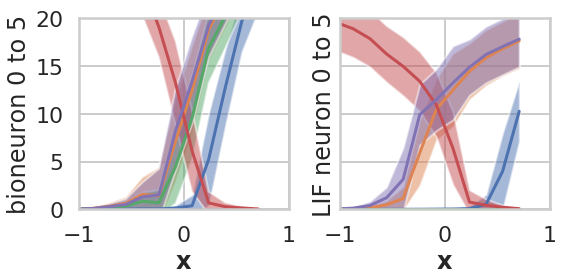

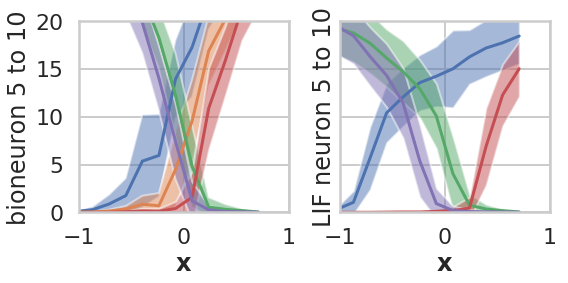

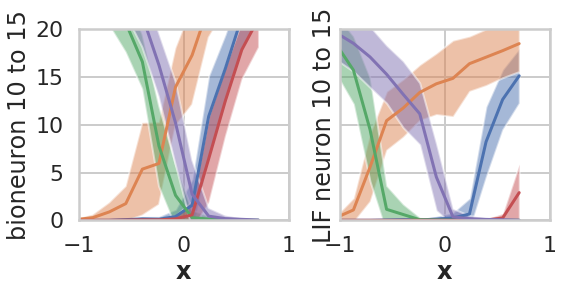

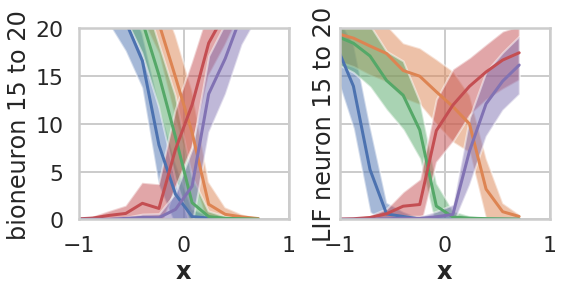

nonzero neurons: 20


In [5]:
reg = 0.1
n_neurons = 20
tau = 0.1
d0 = np.zeros((n_neurons, 1))
seed = 0
max_rates = Uniform(20, 20)
intercepts = Uniform(-0.8, 0.8)
t = 10
dt = 0.001
dt_neuron = 0.025  # ms
freq = 1
stim_func = nengo.processes.WhiteSignal(period=t, high=freq, rms=1, seed=seed)

neuron_type = DurstewitzNeuron(dt_neuron=dt_neuron, DA=False)
h = Lowpass(0.1)

data0 = go(n_neurons, neuron_type, t, dt, d0, h, 
    freq=freq, tau=tau, seed=seed,
    max_rates=max_rates, intercepts=intercepts, stim_func=stim_func)

gain1 = data0['gain']
bias1 = data0['bias']
max_rates1 = data0['max_rates']
intercepts1 = data0['intercepts']

tar = Lowpass(tau).filt(data0['tar'])
a = h.filt(data0['spk'])
lif = Lowpass(tau).filt(data0['lif'])
plot_tuning(tar, a, lif, max_rates, neurons_per_plot=5)
print('nonzero neurons:', np.count_nonzero(np.sum(a, axis=0)))

/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'opt' on '<Connection from <Ensemble (unlabeled) at 0x7f80d0153128> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'k_weight' on '<Connection from <Ensemble (unlabeled) at 0x7f80d0153128> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/builder/ensemble.py:97: NengoWarning: Specifying the gains and biases for <Ensemble "ens"> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens))
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'biasspike' on '<Connection from <Ensemble (unlabeled) at 0x7f80d0153128> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning

building  <Connection from <Ensemble (unlabeled) at 0x7f80d0153128> to <Ensemble "ens">>


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


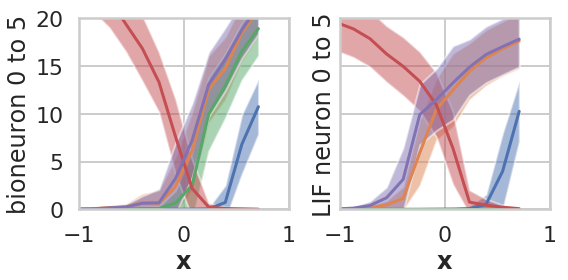

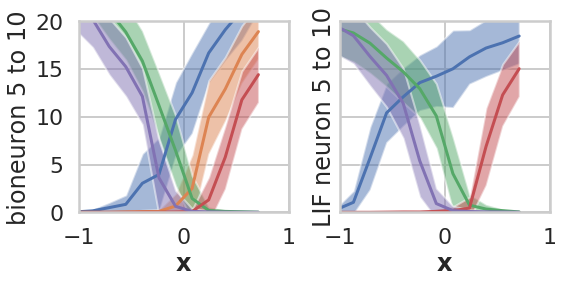

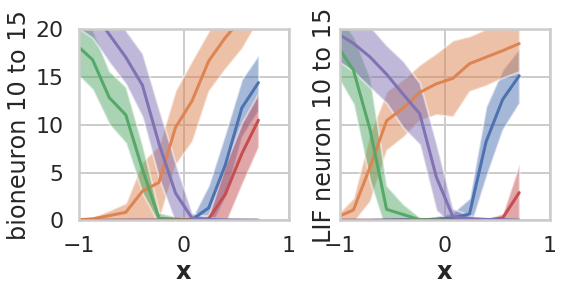

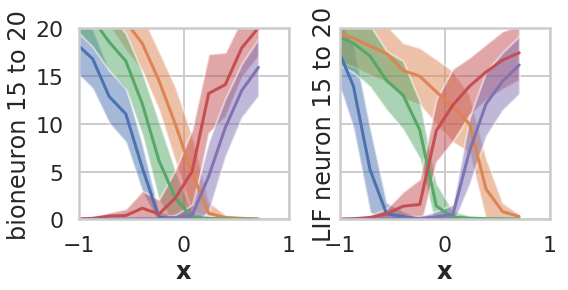

nonzero neurons: 20


In [9]:
neuron_type.max_rates = max_rates1
neuron_type.intercepts = intercepts1

data1 = go(n_neurons, neuron_type, t, dt, d0, h, 
    freq=freq, tau=tau, seed=seed, stim_func=stim_func,
    max_rates=max_rates1, intercepts=intercepts1, gain=gain1, bias=bias1,
    pre_x_opt=False, k_weight=3e2)

tar = Lowpass(tau).filt(data1['tar'])
a = h.filt(data1['spk'])
lif1 = Lowpass(tau).filt(data1['lif'])
plot_tuning(tar, a, lif1, max_rates, neurons_per_plot=5)
print('nonzero neurons:', np.count_nonzero(np.sum(a, axis=0)))

/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'opt' on '<Connection from <Ensemble (unlabeled) at 0x7f80d036b6d8> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'k_weight' on '<Connection from <Ensemble (unlabeled) at 0x7f80d036b6d8> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)


finding gain and bias assuming on/off spiking inputs...


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

did not find good gain/bias for neuron 0
optimized neuron 1
did not find good gain/bias for neuron 2
optimized neuron 3
optimized neuron 4
optimized neuron 5
did not find good gain/bias for neuron 6
optimized neuron 7
did not find good gain/bias for neuron 8
optimized neuron 9
did not find good gain/bias for neuron 10
optimized neuron 11
did not find good gain/bias for neuron 12
did not find good gain/bias for neuron 13
optimized neuron 14
did not find good gain/bias for neuron 15
optimized neuron 16
optimized neuron 17
optimized neuron 18
optimized neuron 19
building  <Connection from <Ensemble (unlabeled) at 0x7f80d036b6d8> to <Ensemble "ens">>


/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'biasspike' on '<Connection from <Ensemble (unlabeled) at 0x7f80d036b6d8> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'transmitspike' on '<Connection from <Ensemble (unlabeled) at 0x7f80d036b6d8> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


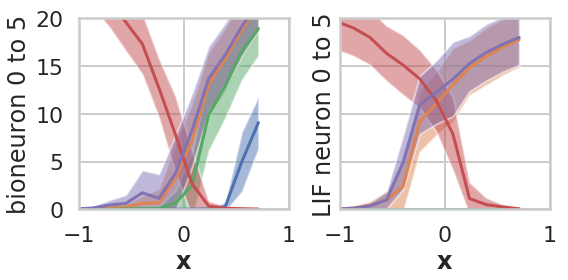

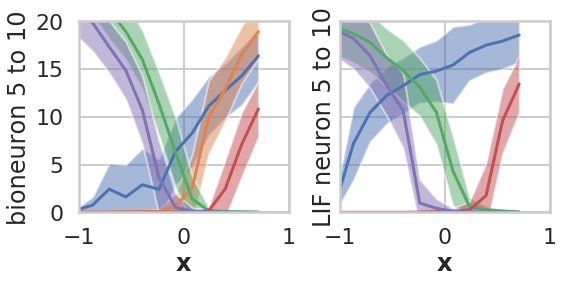

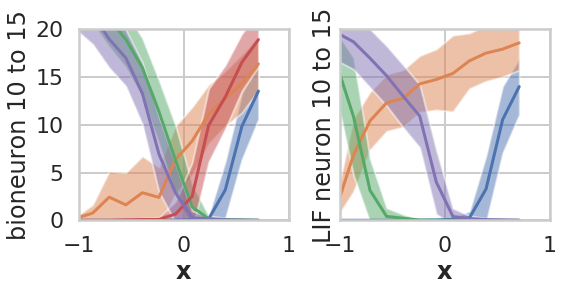

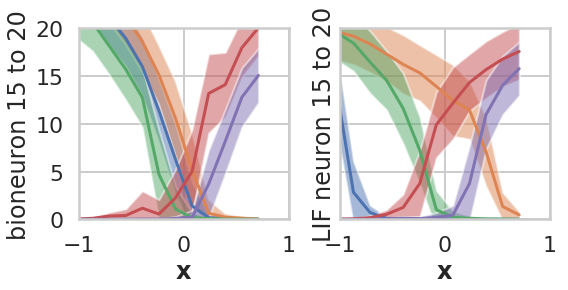

nonzero neurons: 20


In [18]:
reg = 0.1
n_neurons = 20
tau = 0.1
d0 = np.zeros((n_neurons, 1))
seed = 0
max_rates = Uniform(20, 20)
intercepts = Uniform(-1, 1)
t = 10
dt = 0.001
dt_neuron = 0.025  # ms
freq = 1
stim_func = nengo.processes.WhiteSignal(period=t, high=freq, rms=1, seed=seed)

neuron_type = DurstewitzNeuron(dt_neuron=dt_neuron, DA=False)
h = Lowpass(0.1)

data0 = go(n_neurons, neuron_type, t, dt, d0, h, 
    freq=freq, tau=tau, seed=seed,
    max_rates=max_rates, intercepts=intercepts, stim_func=stim_func)

gain1 = data0['gain']
bias1 = data0['bias']
max_rates1 = data0['max_rates']
intercepts1 = data0['intercepts']

tar = Lowpass(tau).filt(data0['tar'])
a = h.filt(data0['spk'])
lif = Lowpass(tau).filt(data0['lif'])
plot_tuning(tar, a, lif, max_rates, neurons_per_plot=5)
print('nonzero neurons:', np.count_nonzero(np.sum(a, axis=0)))

# Control Structure 2

In [19]:
def update_h(stim_data, target_data, spk_data,
        lambda_c=1e-1, lambda_d=1e-1, order=1, n_samples=10000,
        min_d=-1e-2, max_d=1e-2, dt=0.001, tau=0.1, 
        mean_taus=[0.1], std_taus=[0.01], min_tau=1e-4, max_tau=1e0):

    from scipy.linalg import block_diag

    def sample_prior(n_samples, order, mean_taus, std_taus, min_tau, rng=np.random.RandomState(seed=0)):
        """Return n samples (taus) from the prior of a k'th-order synapse."""
        taus = np.zeros((n_samples, order))
        for o in range(order):
            taus[:, o] = rng.normal(mean_taus[o], std_taus[o], size=(n_samples, )).clip(min_tau)
        return taus
    
    for att in range(10):  # attempts
        assert len(mean_taus) == order
        assert len(std_taus) == order
        taus = sample_prior(n_samples, order, mean_taus, std_taus, min_tau)

        poles = -1. / taus
        n_steps = spk_data.shape[0]
        n_neurons = spk_data.shape[1]
        assert poles.shape == (n_samples, order)

        tf_params = np.zeros((n_samples, order))
        for i in range(n_samples):
            sys = LinearSystem(([], poles[i, :], 1 / np.prod(taus[i, :])))   # (zeros, poles, gain)
            assert len(sys) == order
            assert np.allclose(sys.dcgain, 1)
            den_normalized = np.asarray(sys.den / sys.num[0])
            assert len(den_normalized) == order + 1
            assert np.allclose(den_normalized[-1], 1)  # since normalized
            # tf_params ordered from lowest to highest, ignoring c_0 = 1, i.e., [c_1, ..., c_k]
            tf_params[i, :] = den_normalized[:-1][::-1]

        # We assume c_i are independent by setting the off-diagonals to zero
        C = np.cov(tf_params, rowvar=False)
        if order == 1:
            C = C*np.eye(1)
        Q = np.linalg.inv(C)
        c0 = np.mean(tf_params, axis=0)
        d0 = np.ones((n_neurons, ))
        cd0 = np.hstack((c0, d0))
        assert Q.shape == (order, order)
        assert cd0.shape == (order+n_neurons,)

        diff = (1. - ~z) / dt
        A = np.zeros((n_steps, order + n_neurons))
        deriv_n = target_data
        for i in range(order):
            deriv_n = diff.filt(deriv_n, y0=0, dt=dt)
            A[:, i] = deriv_n.ravel()  # todo: D>1
        for n in range(n_neurons):
            A[:, order+n] = spk_data[:, n]
        b = tau  # set on pre_u ==> supv connection in network
        Y = (b*stim_data - target_data)
        smoother = Lowpass(tau)
        A = smoother.filt(A, y0=0, dt=dt, axis=0)
        Y = smoother.filt(Y, y0=0, dt=dt)

        # construct block diagonal matrix with different regularizations for filter coefficients and decoders
        L = block_diag(lambda_c*Q, lambda_d*np.eye(n_neurons))
        gamma = A.T.dot(A) + L
        upsilon = A.T.dot(Y) + L.dot(cd0).reshape((order+n_neurons, 1))  # optional term with tikhonov regularization

        cd = np.linalg.inv(gamma).dot(upsilon).ravel()
        c_new = cd[:order]
        d_new = -1.*cd[-n_neurons:]
        assert c_new.shape==(order,)
        assert d_new.shape==(n_neurons,)
        print('taus attempt %s, nonzero d %s, tau=%s: '%(att, np.count_nonzero(d_new+1), c_new))
        for n in range(n_neurons):
            if d_new[n] > max_d or d_new[n] < min_d:
                d_new[n] = 0
        d_new = d_new.reshape((n_neurons, 1))
        h_new = 1. / (1 + sum(c_new[i] * s**(i+1) for i in range(order)))
        assert np.allclose(h_new.dcgain, 1)
        if np.all(c_new > 0):
            break
        else:
            mean_taus[-1] *= 2
            lambda_c *= 2
            lambda_d *= 2

    return h_new, d_new

In [20]:
def go2(n_neurons, neuron_type, neuron_type2, t, dt, d, h,
        stim_func=lambda ti: np.cos(2*np.pi*ti), tau=0.01,
        max_rates=Default, intercepts=Default, gain=Default, bias=Default,
        pre_x_opt=False, x_x2_opt=False, pre_x_gain=0, pre_x_bias=0, x_x2_gain=0, x_x2_bias=0, k_weight=3e2,
        freq=1, seed=0, seed2=1):
    norm_stim, norm_filt = norms(freq, seed, tau, t, stim_func, dt=dt)
    with nengo.Network() as model:
        stim = nengo.Node(stim_func)
        target = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        target2 = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        pre = nengo.Ensemble(100, 1, radius=1, max_rates=Uniform(20, 20),
            seed=seed2, neuron_type=nengo.LIF())
        pre2 = nengo.Ensemble(100, 1, radius=1, max_rates=Uniform(20, 20),
            seed=seed2*2, neuron_type=nengo.LIF())
        x = nengo.Ensemble(n_neurons, 1,
            gain=gain, bias=bias, max_rates=max_rates, intercepts=intercepts, 
            neuron_type=neuron_type, 
            seed=seed2, label='ens')
        x2 = nengo.Ensemble(n_neurons, 1,
            gain=gain, bias=bias, max_rates=max_rates, intercepts=intercepts, 
            neuron_type=neuron_type2, 
            seed=seed2, label='ens2')
        lif = nengo.Ensemble(n_neurons, 1, 
            neuron_type=nengo.LIF(), max_rates=max_rates, intercepts=intercepts, 
            seed=seed2, label='lif')
        lif2 = nengo.Ensemble(n_neurons, 1, 
            neuron_type=nengo.LIF(), max_rates=max_rates, intercepts=intercepts, 
            seed=seed2, label='lif2')
        nengo.Connection(stim, pre, synapse=None, transform=1.0/norm_filt, seed=seed2)
        nengo.Connection(stim, pre2, synapse=None, transform=1.0/norm_filt, seed=seed2*2)
        nengo.Connection(stim, target, synapse=Lowpass(tau), transform=1.0/norm_filt, seed=seed2)
        nengo.Connection(target, target2, synapse=Lowpass(tau), seed=seed2)
        pre_x = nengo.Connection(pre, x, synapse=Lowpass(tau), transform=1.0, seed=seed2)
        pre_x.opt = pre_x_opt
        pre_x.k_weight = k_weight
        pre_x.gain = pre_x_gain
        pre_x.bias = pre_x_bias
        nengo.Connection(pre, lif, synapse=Lowpass(tau), seed=seed2)
        x_x2 = nengo.Connection(x, x2, synapse=h, solver=NoSolver(d), seed=seed2)
        x_x2.opt = x_x2_opt
        x_x2.k_weight = k_weight
        x_x2.gain = x_x2_gain
        x_x2.bias = x_x2_bias
        nengo.Connection(lif, lif2, synapse=Lowpass(tau), seed=seed2)
        p_stim = nengo.Probe(stim, synapse=None)
        p_tar = nengo.Probe(target, synapse=None)
        p_tar2 = nengo.Probe(target2, synapse=None)
        p_s = nengo.Probe(x.neurons, 'spikes', synapse=None)
        p_s2 = nengo.Probe(x2.neurons, 'spikes', synapse=None)
        p_v = nengo.Probe(x.neurons, 'voltage', synapse=None)
        p_v2 = nengo.Probe(x2.neurons, 'voltage', synapse=None)
        p_lif = nengo.Probe(lif.neurons, 'spikes', synapse=None)
        p_lif2 = nengo.Probe(lif2.neurons, 'spikes', synapse=None)
   
    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(t)
        
    return dict(
        trange=sim.trange(),
        stim=sim.data[p_stim],
        tar=sim.data[p_tar],
        spk=sim.data[p_s],
        v=sim.data[p_v],
        tar2=sim.data[p_tar2],
        spk2=sim.data[p_s2],
        v2=sim.data[p_v2],
        lif=sim.data[p_lif],
        lif2=sim.data[p_lif2],
        gain=sim.data[x].gain,
        bias=sim.data[x].bias,
        max_rates=sim.data[x].max_rates,
        intercepts=sim.data[x].intercepts,
        pre_x_gain = pre_x.gain,
        pre_x_bias = pre_x.bias,
        x_x2_gain = x_x2.gain,
        x_x2_bias = x_x2.bias,)

# Simulations 2

/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'opt' on '<Connection from <Ensemble (unlabeled) at 0x7f80d5ea1eb8> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'k_weight' on '<Connection from <Ensemble (unlabeled) at 0x7f80d5ea1eb8> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'gain' on '<Connection from <Ensemble (unlabeled) at 0x7f80d5ea1eb8> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'bias' on '<Connection from <Ensemble (unlabeled) at 0x7f80d5ea1eb8> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating n

finding gain and bias assuming on/off spiking inputs...


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

did not find good gain/bias for neuron 0
optimized neuron 1
optimized neuron 2
did not find good gain/bias for neuron 3
optimized neuron 4
did not find good gain/bias for neuron 5
optimized neuron 6
optimized neuron 7
did not find good gain/bias for neuron 8
optimized neuron 9
building  <Connection from <Ensemble (unlabeled) at 0x7f80d5ea1eb8> to <Ensemble "ens">>


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'biasspike' on '<Connection from <Ensemble (unlabeled) at 0x7f80d5ea1eb8> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'transmitspike' on '<Connection from <Ensemble (unlabeled) at 0x7f80d5ea1eb8> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


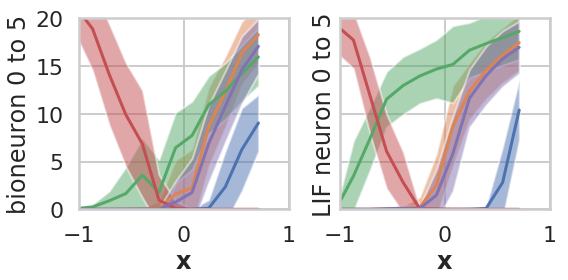

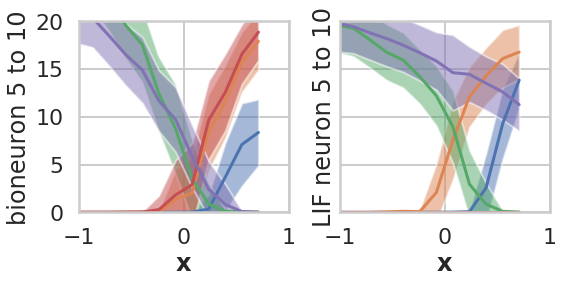

nonzero bioneurons: 10
nonzero LIF neurons: 9


In [21]:
reg = 0.1
n_neurons = 10
tau = 0.1
seed = 0
t = 10
dt = 0.001
dt_neuron = 0.025  # ms
freq = 1
gain0 = Default
bias0 = Default
max_rates0 = Uniform(20, 20)
intercepts0 = Uniform(-1, 1)
d0 = np.zeros((n_neurons, 1))
h0 = Lowpass(0.1)
stim_func = nengo.processes.WhiteSignal(period=t, high=freq, rms=1, seed=seed)
neuron_type = DurstewitzNeuron(dt_neuron=dt_neuron, DA=False)
neuron_type2 = nengo.LIF()

data1 = go2(n_neurons, neuron_type, neuron_type2, t, dt, d0, h0,
    freq=freq, tau=tau, seed=seed, stim_func=stim_func,
    max_rates=max_rates0, intercepts=intercepts0, gain=gain0, bias=bias0)

tar1 = Lowpass(tau).filt(data1['tar'])
a1 = h0.filt(data1['spk'])
lif1 = Lowpass(tau).filt(data1['lif'])
plot_tuning(tar1, a1, lif1, max_rates0, neurons_per_plot=5)
print('nonzero bioneurons:', np.count_nonzero(np.sum(a1, axis=0)))
print('nonzero LIF neurons:', np.count_nonzero(np.sum(lif1, axis=0)))

/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'opt' on '<Connection from <Ensemble (unlabeled) at 0x7f80d13d5978> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'k_weight' on '<Connection from <Ensemble (unlabeled) at 0x7f80d13d5978> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'gain' on '<Connection from <Ensemble (unlabeled) at 0x7f80d13d5978> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'bias' on '<Connection from <Ensemble (unlabeled) at 0x7f80d13d5978> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating n

building  <Connection from <Ensemble (unlabeled) at 0x7f80d13d5978> to <Ensemble "ens">>
building  <Connection from <Ensemble "ens"> to <Ensemble "ens2">>


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


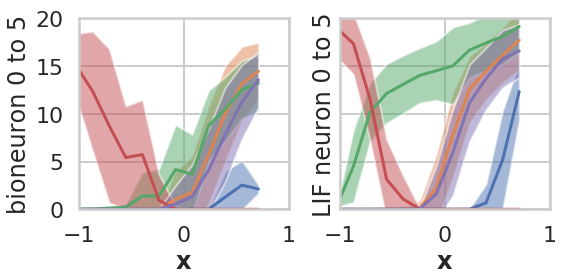

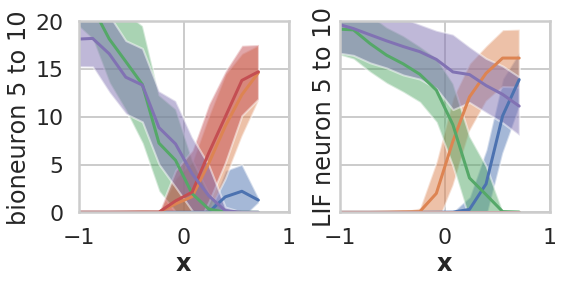

nonzero bioneurons: 10
nonzero LIF neurons: 9


In [22]:
lambda_d = 1e-1
h1 = Lowpass(tau)
d1 = LstsqL2(reg=lambda_d)(h1.filt(data1['spk']), h1.filt(data1['tar']))[0]
gain1 = data1['gain']
bias1 = data1['bias']
max_rates1 = data1['max_rates']
intercepts1 = data1['intercepts']
neuron_type.max_rates = max_rates1
neuron_type.intercepts = intercepts1
neuron_type2 = neuron_type

data2 = go2(n_neurons, neuron_type, neuron_type2, t, dt, d1, h1,
    freq=freq, tau=tau, seed=seed, stim_func=stim_func,
    max_rates=max_rates0, intercepts=intercepts0, gain=gain1, bias=bias1)

tar2 = Lowpass(tau).filt(data2['tar2'])
a2 = h0.filt(data2['spk2'])
lif2 = Lowpass(tau).filt(data2['lif2'])
plot_tuning(tar2, a2, lif2, max_rates0, neurons_per_plot=5)
print('nonzero bioneurons:', np.count_nonzero(np.sum(a2, axis=0)))
print('nonzero LIF neurons:', np.count_nonzero(np.sum(lif2, axis=0)))

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 10, tau=[0.0917]: 


/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'opt' on '<Connection from <Ensemble (unlabeled) at 0x7f80d5e6d550> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'k_weight' on '<Connection from <Ensemble (unlabeled) at 0x7f80d5e6d550> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'gain' on '<Connection from <Ensemble (unlabeled) at 0x7f80d5e6d550> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'bias' on '<Connection from <Ensemble (unlabeled) at 0x7f80d5e6d550> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating n

building  <Connection from <Ensemble (unlabeled) at 0x7f80d5e6d550> to <Ensemble "ens">>
building  <Connection from <Ensemble "ens"> to <Ensemble "ens2">>


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


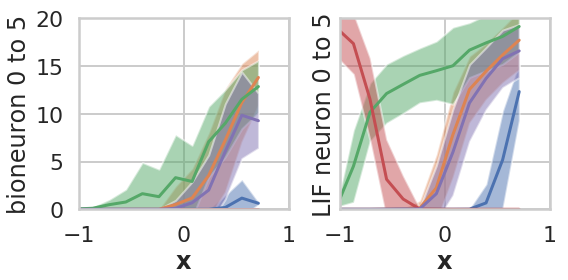

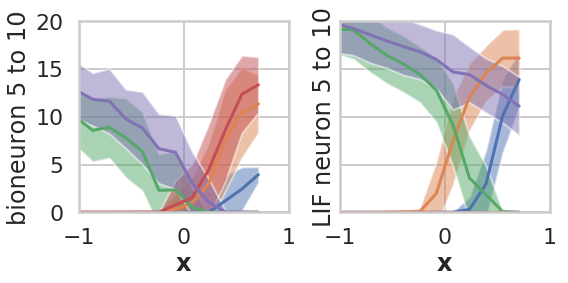

In [23]:
lambda_c = 1e-1
lambda_d = 1e-1
h1, d1 = update_h(data1['stim'], data1['tar'], data1['spk'],
        lambda_c=1e-1, lambda_d=1e-1, order=1, n_samples=10000,
        min_d=-1e-2, max_d=1e-2, dt=0.001, tau=0.1, 
        mean_taus=[0.1], std_taus=[0.01], min_tau=1e-4, max_tau=1e0)

data3 = go2(n_neurons, neuron_type, neuron_type2, t, dt, d1, h1,
    freq=freq, tau=tau, seed=seed, stim_func=stim_func,
    max_rates=max_rates0, intercepts=intercepts0, gain=gain1, bias=bias1)

tar3 = Lowpass(tau).filt(data3['tar2'])
a3 = h0.filt(data3['spk2'])
lif3 = Lowpass(tau).filt(data3['lif2'])
plot_tuning(tar3, a3, lif3, max_rates0, neurons_per_plot=5)

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[-0.]], B=[[1.]], C=[[-1000.]], D=[[1000.]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 10, tau=[9.17543e-02 9.03721e-05]: 


/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'opt' on '<Connection from <Ensemble (unlabeled) at 0x7f80d04f6dd8> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'k_weight' on '<Connection from <Ensemble (unlabeled) at 0x7f80d04f6dd8> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'gain' on '<Connection from <Ensemble (unlabeled) at 0x7f80d04f6dd8> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'bias' on '<Connection from <Ensemble (unlabeled) at 0x7f80d04f6dd8> to <Ensemble "ens">>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating n

building  <Connection from <Ensemble (unlabeled) at 0x7f80d04f6dd8> to <Ensemble "ens">>
building  <Connection from <Ensemble "ens"> to <Ensemble "ens2">>


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


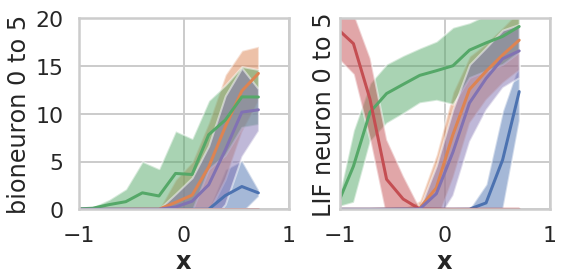

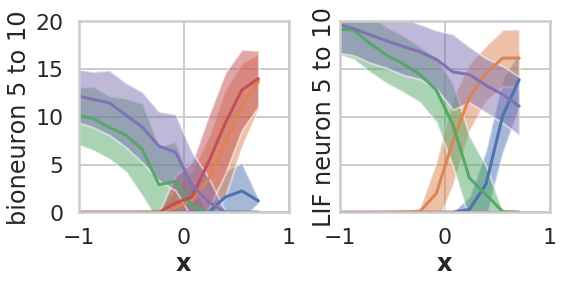

In [24]:
lambda_c = 1e-1
lambda_d = 1e-1
h1, d1 = update_h(data1['stim'], data1['tar'], data1['spk'],
        lambda_c=1e-1, lambda_d=1e-1, order=2, n_samples=10000,
        min_d=-1e-2, max_d=1e-2, dt=0.001, tau=0.1, 
        mean_taus=[0.001, 0.1], std_taus=[0.0001, 0.01], min_tau=1e-4, max_tau=1e0)

data3 = go2(n_neurons, neuron_type, neuron_type2, t, dt, d1, h1,
    freq=freq, tau=tau, seed=seed, stim_func=stim_func,
    max_rates=max_rates0, intercepts=intercepts0, gain=gain1, bias=bias1)

tar3 = Lowpass(tau).filt(data3['tar2'])
a3 = h0.filt(data3['spk2'])
lif3 = Lowpass(tau).filt(data3['lif2'])
plot_tuning(tar3, a3, lif3, max_rates0, neurons_per_plot=5)